In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
feature_0_bkg = np.random.randn(10000,1)
feature_0_sig = np.random.randn(10000,1)+3

feature_1_bkg = np.random.randn(10000,1)*5-20
feature_1_sig = np.random.randn(10000,1)*4-25

feature_2_bkg = np.random.rayleigh(1,10000).reshape(10000,1)
feature_2_sig = np.random.rayleigh(4,10000).reshape(10000,1)

feature_3_bkg = np.random.triangular(-3,0,8,10000).reshape(10000,1)
feature_3_sig = np.random.triangular(0,4,6,10000).reshape(10000,1)

labels_bkg = np.zeros((10000,1))
labels_sig = np.ones((10000,1))

In [21]:
data_bkg = np.concatenate((feature_0_bkg,
                           feature_1_bkg,
                           feature_2_bkg,
                           feature_3_bkg,
                           labels_bkg),
                          axis=1)

data_sig = np.concatenate((feature_0_sig,
                           feature_1_sig,
                           feature_2_sig,
                           feature_3_sig,
                           labels_sig),
                          axis=1)

In [22]:
data = np.concatenate((data_bkg,data_sig),axis=0)
np.random.shuffle(data)

In [23]:
features = data[:,:-1]
labels = data[:,-1]

In [24]:
import hist

In [25]:
hist0 = (hist.Hist.new.Reg(50, -7, 7, name="var0", label="Variable 0")
                     .Reg(50, -45, 5, name="var1", label="Variable 1")
                     .Reg(50, 0, 15, name="var2", label="Variable 2")
                     .Reg(50, -4, 9, name="var3", label="Variable 3")
                     .IntCat(range(2), name="label", label="Truth Label (Sig/Bkg)")
                     .Weight())

In [26]:
hist0.fill(var0 = feature_0_bkg.reshape(feature_0_bkg.shape[0],),
           var1 = feature_1_bkg.reshape(feature_1_bkg.shape[0],),
           var2 = feature_2_bkg.reshape(feature_2_bkg.shape[0],),
           var3 = feature_3_bkg.reshape(feature_3_bkg.shape[0],),
           label = np.zeros(len(feature_0_bkg)))

hist0.fill(var0 = feature_0_sig.reshape(feature_0_sig.shape[0],),
           var1 = feature_1_sig.reshape(feature_1_sig.shape[0],),
           var2 = feature_2_sig.reshape(feature_2_sig.shape[0],),
           var3 = feature_3_sig.reshape(feature_3_sig.shape[0],),
           label = np.ones(len(feature_0_sig)))

Hist(
  Regular(50, -7, 7, name='var0', label='Variable 0'),
  Regular(50, -45, 5, name='var1', label='Variable 1'),
  Regular(50, 0, 15, name='var2', label='Variable 2'),
  Regular(50, -4, 9, name='var3', label='Variable 3'),
  IntCategory([0, 1], name='label', label='Truth Label (Sig/Bkg)'),
  storage=Weight()) # Sum: WeightedSum(value=19989, variance=19989) (WeightedSum(value=20000, variance=20000) with flow)

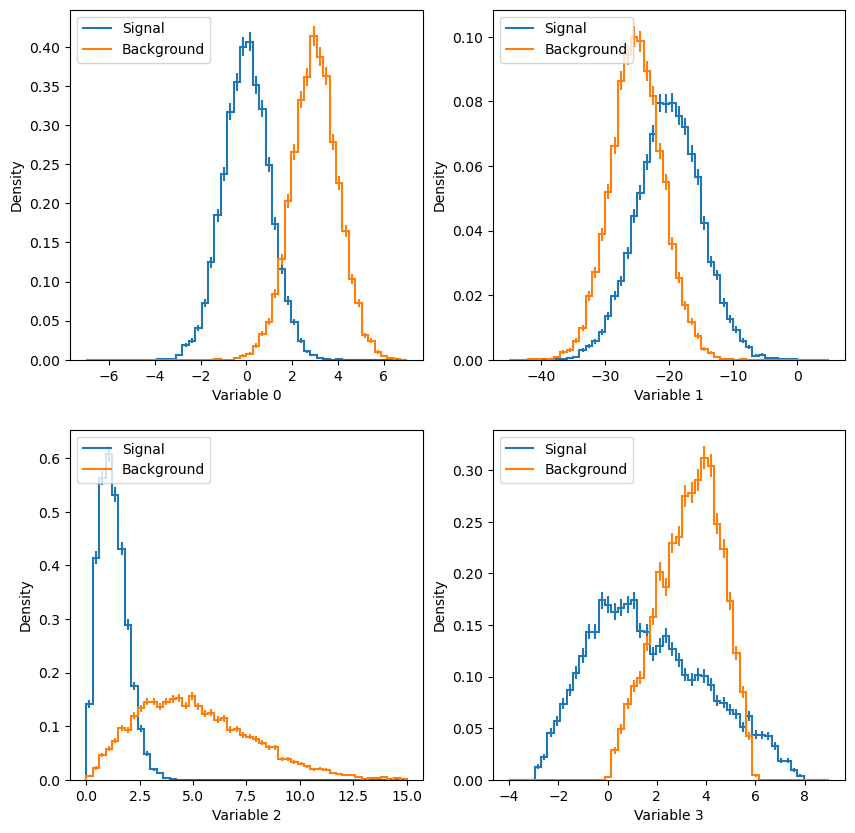

In [27]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
hist0.project("label", "var0").plot(density=True, ax=axs[0,0])
axs[0,0].legend(["Signal","Background"], loc = 'upper left')
axs[0,0].set_ylabel("Density")

hist0.project("label", "var1").plot(density=True, ax=axs[0,1])
axs[0,1].legend(["Signal","Background"], loc = 'upper left')
axs[0,1].set_ylabel("Density")

hist0.project("label", "var2").plot(density=True, ax=axs[1,0])
axs[1,0].legend(["Signal","Background"], loc = 'upper left')
axs[1,0].set_ylabel("Density")

hist0.project("label", "var3").plot(density=True, ax=axs[1,1])
axs[1,1].legend(["Signal","Background"], loc = 'upper left')
axs[1,1].set_ylabel("Density")

plt.show()

In [28]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader
import torch

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

In [29]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [30]:
# create dataset
data_torch = dataset(features,labels)

In [31]:
# shuffle
from torch.utils.data import random_split
from torch import Generator

train, validation = random_split(data_torch, 
                                 [int(0.8*20000), int(0.2*20000)], # fractions for train, validation
                                 generator=torch.Generator().manual_seed(42))

In [32]:
trainloader = DataLoader(train,batch_size=64,shuffle=True)
valloader = DataLoader(validation,batch_size=len(validation),shuffle=True)

In [33]:
#hyper parameters
learning_rate = 0.001
epochs = 200

# Model , Optimizer, Loss
model = Net(input_shape=features.shape[1])
model = torch.jit.script(model)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss() # mean squared error loss function

In [34]:
model

RecursiveScriptModule(
  original_name=Net
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

In [35]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    model.train()
    for j,(x_train,y_train) in enumerate(trainloader):
    
        #calculate output
        output = model(x_train)
 
        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))
 
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    model.eval()
    for m,n in valloader:
        pred = model(m).reshape(-1).detach().numpy().round()
        acc = np.mean(pred==np.array(n))

    losses.append(loss.item())
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.19976788759231567	 accuracy : 0.6875
epoch 1	loss : 0.18639585375785828	 accuracy : 0.83175
epoch 2	loss : 0.1535361111164093	 accuracy : 0.84875
epoch 3	loss : 0.13417182862758636	 accuracy : 0.85675
epoch 4	loss : 0.1244383379817009	 accuracy : 0.859
epoch 5	loss : 0.12317785620689392	 accuracy : 0.8605
epoch 6	loss : 0.11619894206523895	 accuracy : 0.87225
epoch 7	loss : 0.1095583513379097	 accuracy : 0.87925
epoch 8	loss : 0.08110716938972473	 accuracy : 0.88525
epoch 9	loss : 0.095755934715271	 accuracy : 0.89375
epoch 10	loss : 0.06724275648593903	 accuracy : 0.89925
epoch 11	loss : 0.08259817212820053	 accuracy : 0.907
epoch 12	loss : 0.0821436420083046	 accuracy : 0.91175
epoch 13	loss : 0.08724502474069595	 accuracy : 0.91975
epoch 14	loss : 0.08559653908014297	 accuracy : 0.9245
epoch 15	loss : 0.06827782839536667	 accuracy : 0.9315
epoch 16	loss : 0.08234484493732452	 accuracy : 0.935
epoch 17	loss : 0.06926288455724716	 accuracy : 0.93975
epoch 18	loss : 0.

Text(0, 0.5, 'loss')

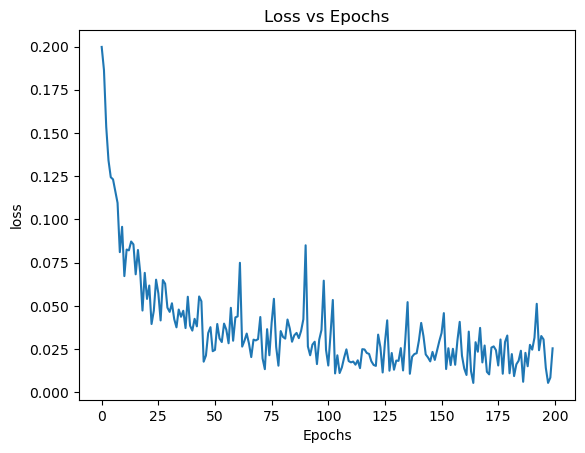

In [36]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

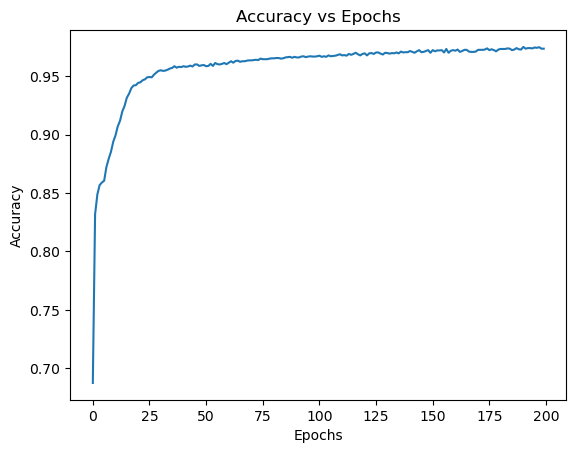

In [37]:
#plotting the accuracy
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [38]:
model

RecursiveScriptModule(
  original_name=Net
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

In [39]:
torch.jit.save(model, "trained_testmodel.pt")